In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Subset, WeightedRandomSampler
import torchvision
from torch.autograd import Variable
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as transforms


import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

import os
import seaborn as sns
import itertools
import PIL
from PIL import Image
import warnings
import splitfolders

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Preprocessing data

In [9]:
#DONT RUN THIS BLOCK FOR NOW PLZ
splitfolders.ratio("../Comp_472 Group Project - Copy/all", output="../Comp_472 Group Project - Copy/dataset/all", seed=0, ratio=(.8, 0.1,0.1))
#splitfolders.ratio("../Comp_472 Group Project - Copy/female", output="../Comp_472 Group Project - Copy/dataset/female", seed=0, ratio=(.8, 0.1,0.1))
#splitfolders.ratio("../Comp_472 Group Project - Copy/male", output="../Comp_472 Group Project - Copy/dataset/male", seed=0, ratio=(.8, 0.1,0.1))

Copying files: 3804 files [00:04, 822.11 files/s] 
Copying files: 1928 files [00:09, 199.95 files/s]
Copying files: 1876 files [00:09, 204.67 files/s]


In [17]:
#resize the image into 32*32 pixels
train_transform = torchvision.transforms.Compose([transforms.ToTensor(),
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomCrop(32),
                                                 ])
targets = ['N95mask', 'clothmask', 'nomask', 'surgicalmask']
#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [18]:
#train data
data_dir = "../Comp_472 Group Project - Copy/dataset/all/train"
train_dataset = torchvision.datasets.ImageFolder(data_dir, transform = train_transform)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=700, shuffle = True
)


In [19]:
#test data
test_dir = "../Comp_472 Group Project - Copy/dataset/all/test"
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform = train_transform)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle = True
)

#### Modeling

In [22]:
#Model refence from Internet with modification of numbers
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )
        
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, K)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.12)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.8)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.6)
        x = self.fc3(x)
        return x

In [23]:
n = len(set(train_dataset.targets))
model = CNN(n)
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bi

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

#### Training

In [25]:
#modify from https://www.programcreek.com/python/?CodeExample=train+epoch
def train(model, criterion, optimizer, trainloader, epochs):
  train_losses = np.zeros(epochs)

  for i in range(epochs):
    train_loss = []
    for inputs, targets in trainloader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    train_losses[i] = train_loss
    
    print(f'Epoch:{i+1}/{epochs}, Train Loss: {train_loss:.4f}')
    
  return train_losses

In [26]:
#training takes about 5 minute for 20 epochs
train_losses = train(model, criterion, optimizer, trainloader, epochs=20)

Epoch:1/20, Train Loss: 1.4582
Epoch:2/20, Train Loss: 1.0162
Epoch:3/20, Train Loss: 0.8710
Epoch:4/20, Train Loss: 0.7741
Epoch:5/20, Train Loss: 0.7026
Epoch:6/20, Train Loss: 0.6351
Epoch:7/20, Train Loss: 0.5410
Epoch:8/20, Train Loss: 0.5121
Epoch:9/20, Train Loss: 0.4693
Epoch:10/20, Train Loss: 0.4248
Epoch:11/20, Train Loss: 0.3955
Epoch:12/20, Train Loss: 0.3746
Epoch:13/20, Train Loss: 0.3364
Epoch:14/20, Train Loss: 0.2834
Epoch:15/20, Train Loss: 0.2525
Epoch:16/20, Train Loss: 0.2202
Epoch:17/20, Train Loss: 0.1898
Epoch:18/20, Train Loss: 0.1465
Epoch:19/20, Train Loss: 0.1497
Epoch:20/20, Train Loss: 0.1440


In [27]:
PATH = "MyModel.pt"

In [28]:
# save model
torch.save(model, PATH)

In [29]:
# load model
model = torch.load(PATH)
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bi

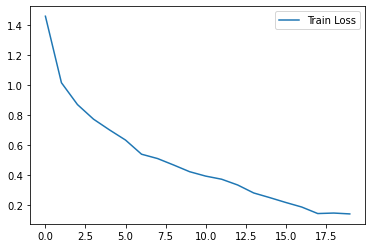

In [48]:
plt.plot(train_losses, label = "Train Loss")
plt.legend()
plt.show()

#### Evaluation

In [80]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for l,p in zip(labels.numpy(), predicted.numpy()):
            y_true.append(targets[l])
            y_pred.append(targets[p])

In [81]:
#Use method from sklearn
#Question: why the accuracy thing keeps changing every time I run it
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")


print(f"Accuracy: {accuracy: .3f}")
print(f"Precision: {precision: .3f}")
print(f"Recall: {recall: .3f}")
print(f"F1-measure: {f1: .3f}")

Accuracy:  0.779
Precision:  0.824
Recall:  0.779
F1-measure:  0.781


In [82]:
#Method found on https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [83]:
confusion_matrix(y_true=y_true, y_pred=y_pred)
cm_plot_labels = targets
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=cm_plot_labels)

[[92  2  0  1]
 [30 58  7  1]
 [13  4 85  1]
 [19  7  0 64]]


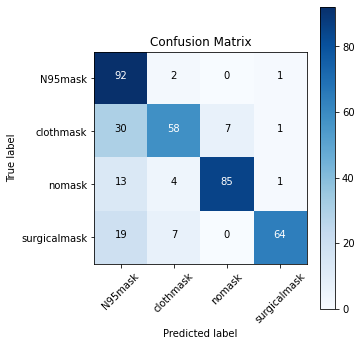

In [84]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix", cmap=plt.cm.Blues)

#### Bias evaluation for female

In [85]:
#female
data_dir0 = "../Comp_472 Group Project - Copy/dataset/female"
train_dataset0 = torchvision.datasets.ImageFolder(data_dir0, transform = train_transform)

trainloader0 = torch.utils.data.DataLoader(
    train_dataset0, batch_size=400, shuffle = True
)

# #female test
# test_dir0 = "../Comp_472 Group Project - Copy/dataset/female/test"
# test_dataset0 = torchvision.datasets.ImageFolder(test_dir0, transform = train_transform)

# testloader0 = torch.utils.data.DataLoader(
#     test_dataset0, batch_size=100, shuffle = True
# )


In [86]:
model.eval()

y_true0 = []
y_pred0 = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in trainloader0:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for l,p in zip(labels.numpy(), predicted.numpy()):
            y_true0.append(targets[l])
            y_pred0.append(targets[p])

In [87]:
accuracy = accuracy_score(y_true0, y_pred0)
precision = precision_score(y_true0, y_pred0, average="weighted")
recall = recall_score(y_true0, y_pred0, average="weighted")
f1 = f1_score(y_true0, y_pred0, average="weighted")


print(f"Accuracy: {accuracy: .3f}")
print(f"Precision: {precision: .3f}")
print(f"Recall: {recall: .3f}")
print(f"F1-measure: {f1: .3f}")

Accuracy:  0.851
Precision:  0.893
Recall:  0.851
F1-measure:  0.853


In [88]:
confusion_matrix(y_true=y_true0, y_pred=y_pred0)
cm_plot_labels = targets
cm0 = confusion_matrix(y_true=y_true0, y_pred=y_pred0, labels=cm_plot_labels)

[[478   3   0   1]
 [149 309  15   2]
 [ 16   1 477   0]
 [ 91   8   1 377]]


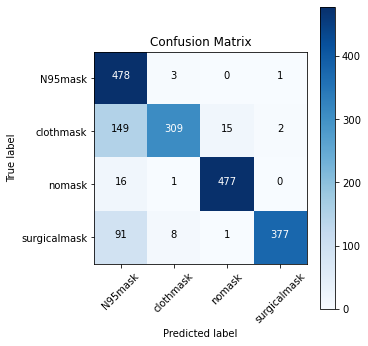

In [89]:
plot_confusion_matrix(cm=cm0, classes=cm_plot_labels, title="Confusion Matrix", cmap=plt.cm.Blues)

#### Bias evaluation for male

In [90]:
#male
data_dir1 = "../Comp_472 Group Project - Copy/dataset/male"
train_dataset1 = torchvision.datasets.ImageFolder(data_dir0, transform = train_transform)

trainloader1 = torch.utils.data.DataLoader(
    train_dataset1, batch_size=350, shuffle = True
)

# #male test
# test_dir1 = "../Comp_472 Group Project - Copy/dataset/male/test"
# test_dataset1 = torchvision.datasets.ImageFolder(test_dir0, transform = train_transform)

# testloader1 = torch.utils.data.DataLoader(
#     test_dataset1, batch_size=100, shuffle = True
# )

In [91]:
model.eval()

y_true1 = []
y_pred1 = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in trainloader1:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for l,p in zip(labels.numpy(), predicted.numpy()):
            y_true1.append(targets[l])
            y_pred1.append(targets[p])

In [92]:
accuracy = accuracy_score(y_true1, y_pred1)
precision = precision_score(y_true1, y_pred1, average="weighted")
recall = recall_score(y_true1, y_pred1, average="weighted")
f1 = f1_score(y_true1, y_pred1, average="weighted")


print(f"Accuracy: {accuracy: .3f}")
print(f"Precision: {precision: .3f}")
print(f"Recall: {recall: .3f}")
print(f"F1-measure: {f1: .3f}")

Accuracy:  0.849
Precision:  0.894
Recall:  0.849
F1-measure:  0.851


In [93]:
confusion_matrix(y_true=y_true1, y_pred=y_pred1)
cm_plot_labels = targets
cm1 = confusion_matrix(y_true=y_true1, y_pred=y_pred1, labels=cm_plot_labels)

[[478   0   2   2]
 [150 311  12   2]
 [ 21   1 472   0]
 [ 93   8   1 375]]


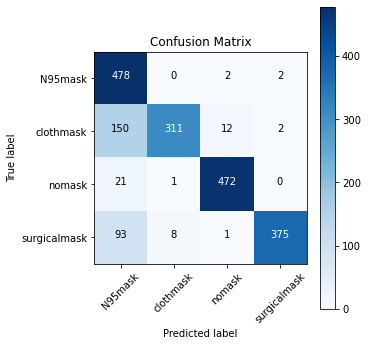

In [94]:
plot_confusion_matrix(cm=cm1, classes=cm_plot_labels, title="Confusion Matrix", cmap=plt.cm.Blues)

# Dont run the below yet

#### Visualize the result

In [64]:
#Method for show the image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [65]:
model.to('cpu')
model.eval()
images, targets = next(iter(testloader))

In [66]:
with torch.no_grad():
    output = model.forward(images)

ps = F.softmax(output,dim=1)

<AxesSubplot:>

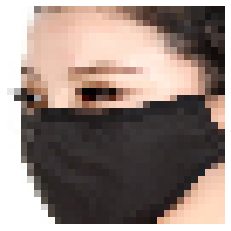

In [111]:
# This block is choosing randomly from the test set and out put the image
#You can run this block multiple times to try different images

rand_img = np.random.randint(100, size=1)[0]
probability = ps[rand_img].data.numpy().squeeze()
imshow(images[rand_img])

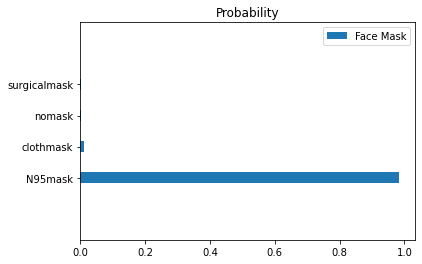

In [112]:
#This block is for showing the prediction of the above image by showing the probability
#You should run it after you choose a image from the block above 
#You should run the whole "Visualize the result" block if you try to run the block below and come back to this one

ind = np.arange(4)
targets = ['N95mask', 'clothmask', 'nomask', 'surgicalmask']
width = 0.35
locations = ind

class_probability = plt.barh(ind, probability, width, alpha=1, label = 'Face Mask')

plt.yticks(np.arange(4))
plt.title('Probability')
plt.yticks(locations,targets)

#legend
plt.legend()
plt.ylim(top=5)
plt.ylim(bottom=-2)
plt.show();

#### User Input

<AxesSubplot:>

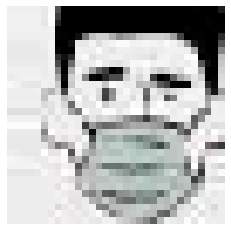

In [141]:
#User can input their own image by putting the image in folder "../Comp_472 Group Project/dataset/userInput/userInput"
#The folder contains an example
#REMEMBER only one image at a time can be process,for multiple images,only the first one in the folder will be considered

user_dir = "../Comp_472 Group Project - Copy/dataset/UserInput"
user_dataset = torchvision.datasets.ImageFolder(user_dir, transform = train_transform)
userloader = torch.utils.data.DataLoader(user_dataset, batch_size=64, shuffle = False)

model.to('cpu')
model.eval()
images, targets = next(iter(userloader))

with torch.no_grad():
    output = model.forward(images)

ps = F.softmax(output,dim=1)

probability = ps[0].data.numpy().squeeze()
imshow(images[0])

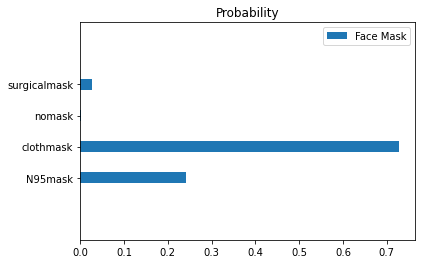

In [142]:
#This block is for showing the prediction of the above image by showing the probability
#You should run it after you choose a image from the block above 

ind = np.arange(4)
targets = ['N95mask', 'clothmask', 'nomask', 'surgicalmask']
width = 0.35
locations = ind

class_probability = plt.barh(ind, probability, width, alpha=1, label = 'Face Mask')

plt.yticks(np.arange(4))
plt.title('Probability')
plt.yticks(locations,targets)

#legend
plt.legend()
plt.ylim(top=5)
plt.ylim(bottom=-2)
plt.show();